# Objective: To build a custom NER to get the list of diseases and their treatment from the dataset.
* Suppose a health tech company aims to connect the medical communities with millions of patients across the country. For this purpose, nowadays companies have a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. On this web platform doctors can easily organise appointments, track past medical records and provide e-prescriptions. As a result, such health tech companies which are providing medical services, prescriptions and online consultations are generating huge data day by day.
* But the major issue with this online approach is that a person with a non-medical background cannot understand the various medical terms.
* With the help of NLP we can process the database and create a ml algorithm to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset which can be easily understood by layman.

## INDEX

* [Data Sourcing](#Data-Sourcing)
* [EDA](#EDA)
    * [Concept Identification](#Concept-Identification)
* [Building custome NER model using CRF](#Building-custome-NER-model-using-CRF)
    * [Defining features for CRF](#Defining-features-for-CRF)
    * [Extracting the features](#Extracting-the-features)
    * [Building the CRF Model](#Building-the-CRF-Model)
* [Model evaluation](#Model-evaluation)
* [Identifying Diseases and Treatments using Custom NER](#Identifying-Diseases-and-Treatments-using-Custom-NER)
* [Predict the treatment for the disease name: 'hereditary retinoblastoma'](#Predict-the-treatment-for-the-disease-name:-'hereditary-retinoblastoma')
* [Conclusion](#Conclusion)

In [1]:
## Installing nlp modules:
# !pip install pycrf                  ## Python library for conditional random field
# !pip install sklearn-crfsuite       ## CRFsuite (python-crfsuite) wrapper which provides scikit-learn-compatible estimator.

# !pip install -U 'scikit-learn<0.24'             ## For version compatibility

In [2]:
# Importing liabraries for NLP related tasks:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from spacy.tokenizer import Tokenizer
import re

In [3]:
## Importing liabraries for general data processing and visualization tasks:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
## Functions for text processing:
def treatment_substitute(text):
    processed_treatments = []
    for x in text:
        x = x.replace(" '", "'")
        x = x.replace("( ", "(")
        x = x.replace(" )", ")")
        processed_treatments.append(x)
    return processed_treatments

def disease_substitute(text):
    text = text.replace(" '", "'")
    text = text.replace("( ", "(")
    text = text.replace(" )", ")")
    return text

## Data Sourcing

* there are four datasets available to us, which are as follows:
    - train_sent
    - test_sent
    - train_label
    - test_label

In [5]:
with open('train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_words_labels = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_words_labels = test_labels_file.readlines()

Lets check out some of the data after loading the dataset:

In [6]:
print(f'first ten records of train_sent file are:\n{train_words[:10]}\n')
print(f'first ten records of train_label file are:\n{train_words_labels[:10]}\n')
print(f'first ten records of test_sent file are:\n{test_words[:10]}\n')
print(f'first ten records of test_label file are:\n{test_words_labels[:10]}')

first ten records of train_sent file are:
['All\n', 'live\n', 'births\n', '>\n', 'or\n', '=\n', '23\n', 'weeks\n', 'at\n', 'the\n']

first ten records of train_label file are:
['O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n']

first ten records of test_sent file are:
['Furthermore\n', ',\n', 'when\n', 'all\n', 'deliveries\n', 'were\n', 'analyzed\n', ',\n', 'regardless\n', 'of\n']

first ten records of test_label file are:
['O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n']


Integrity check of the number of words and their corresponding labels in train and test set:
* There is one-to-one mapping of each label available in the 'train_label' and 'test_label' datasets with the words that are available in the 'train_sent' and 'test_sent' datasets, respectively.

In [7]:
print(f'total words in training dataset including punctuations and new line character are {len(train_words)}')
print(f'total labels corresponding to training dataset are {len(train_words_labels)}\n')
print(f'total words in test dataset including punctuations and new line character are  {len(test_words)}')
print(f'total labels corresponding to test dataset are {len(test_words_labels)}')

total words in training dataset including punctuations and new line character are 48501
total labels corresponding to training dataset are 48501

total words in test dataset including punctuations and new line character are  19674
total labels corresponding to test dataset are 19674


* Each word in this dataset is provided in a single line. So, first, you need to club all these words together to form the sentences. 
* Moreover, there are blank lines given in the dataset that have been highlighted in the image given above. These blank lines indicate that a new sentence is starting from the next line onwards to the next blank line.

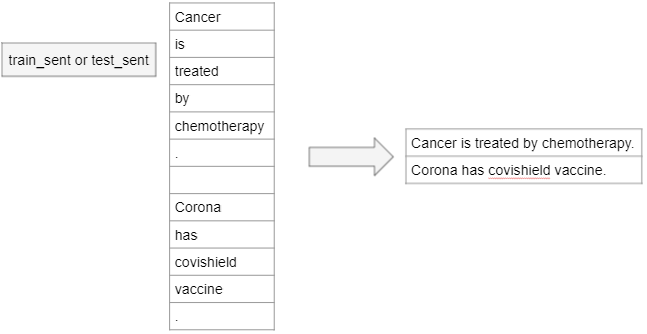

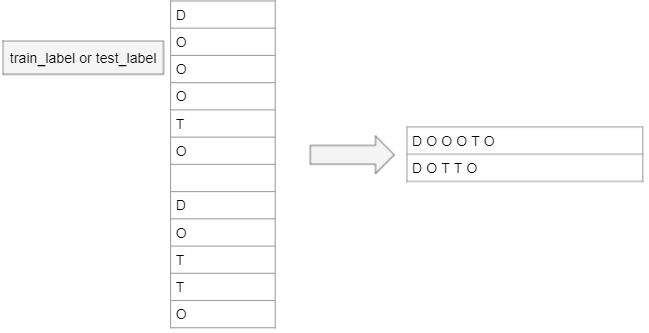

In [8]:
train_sentences = ''.join(train_words).replace('\n',' ').split("  ")
test_sentences = ''.join(test_words).replace('\n',' ').split("  ")

In [9]:
## Removing last item since its a empty string due to presence of '\n' at the end of last word of last sentence: 
del train_sentences[-1]
del test_sentences[-1]

In [10]:
for i,sentence in enumerate(train_sentences[:5]):
    print(f'sentence {i+1} is as follow:\n{sentence}\n')

sentence 1 is as follow:
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )

sentence 2 is as follow:
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )

sentence 3 is as follow:
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )

sentence 4 is as follow:
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )

sentence 5 is as follow:
Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )



In [11]:
for i,sentence in enumerate(test_sentences[:5]):
    print(f'sentence {i+1} is as follow:\n{sentence}\n')

sentence 1 is as follow:
Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )

sentence 2 is as follow:
As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration

sentence 3 is as follow:
The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period

sentence 4 is as follow:
There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )

sentence 5 is as follow:
Fluctuations in ambient temperature are inversely correlated to changes in AFI



In [12]:
train_sentences_labels = ''.join(train_words_labels).replace('\n',' ').split('  ')
test_sentences_labels = ''.join(test_words_labels).replace('\n',' ').split('  ')

In [13]:
## Removing last item since its a empty string due to presence of '\n' at the end of last label of last sentence: 
del train_sentences_labels[-1]
del test_sentences_labels[-1]

In [14]:
for i,sentence in enumerate(train_sentences_labels[:5]):
    print(f'labels for sentence {i+1} is as follow:\n{sentence}\n')

labels for sentence 1 is as follow:
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

labels for sentence 2 is as follow:
O O O O O O O O O O O O O O O O O O O O O O O O O

labels for sentence 3 is as follow:
O O O O O O O O O O O O O O O

labels for sentence 4 is as follow:
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

labels for sentence 5 is as follow:
O O O O O O O O O O O O O O O O O O O O O O



In [15]:
for i,sentence in enumerate(test_sentences_labels[:5]):
    print(f'labels for sentence {i+1} is as follow:\n{sentence}\n')

labels for sentence 1 is as follow:
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

labels for sentence 2 is as follow:
O O O O O O O O O O O O O O O O O O O

labels for sentence 3 is as follow:
O O O O O O O O O O O O O O O O O O O O O O O O

labels for sentence 4 is as follow:
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

labels for sentence 5 is as follow:
O O O O O O O O O O O



### Integrity check: 
* The number of sentences in the processed 'train_sentences' dataset must be equal to the number of lines in the processed 'train_sentences_labels' dataset.

In [16]:
print(f'total sentences in training dataset after joining words are {len(train_sentences)}')
print(f'total lines of labels corresponding to training dataset are {len(train_sentences_labels)}')

total sentences in training dataset after joining words are 2599
total lines of labels corresponding to training dataset are 2599


### Integrity check: 
* The number of sentences in the processed 'test_sentences' dataset must be equal to the number of lines in the processed 'test_sentences_labels' dataset.

In [17]:
print(f'total sentences in test dataset after joining words are {len(test_sentences)}')
print(f'total lines of labels corresponding to test dataset are {len(test_sentences_labels)}')

total sentences in test dataset after joining words are 1056
total lines of labels corresponding to test dataset are 1056


## EDA

### Concept Identification
* As a step of EDA, we will first explore what are the various concepts present in the dataset. For this task, we will use PoS tagging.
* An important point to note here is that we are using both test and train sentences for concept identification.

In [18]:
corpus = train_sentences + test_sentences
print(f'total sentences in corpus are {len(corpus)}')

total sentences in corpus are 3655


Extracting those tokens which have NOUN or PROPN as their PoS tag and finding their frequency:
* For pos tagging we will use Spacy liabrary.
* Specifically, We will use 'en_core_web_sm' model for our task which is a pretrained spacy model.
    * 'en' stands for English language, which means we are working specifically on English language using the spaCy library since our dataset is in english language only.
    * 'core' stands for core NLP tasks, which means we are loading the pre-built models which can perform some of the core NLP-related tasks such as lemmatization or PoS tagging.
    * 'web' is the pre-built model of the spaCy library which we will use for NLP tasks that are trained from web source content such as blogs, social media and comments.
    * 'sm' means small models which are faster and use smaller pipelines but are comparatively less accurate. As a complement to ‘sm’, we can use ‘lg’ or ‘md’ for larger pipelines which will be more accurate than ‘sm’. Since we want lighter model we will use 'sm'.
* To reduce runtime, we will shorten the pipline loading by disabling 'parser' and 'ner' components since we will only be using pos tagging and building our own custom NER model.

In [19]:
## loading pretrained en_core_web_sm’ spacy model into the object ‘model’
## We are also disabling parser and ner to shorten the pipline loading
model = spacy.load("en_core_web_sm",disable=['parser','ner'])

## command for spacy tokenizer to tokenize words only using the "space" rule:
model.tokenizer = Tokenizer(model.vocab, token_match=re.compile(r'\S+').match)

In [20]:
nouns_pronouns = []
for sentence in corpus:
    doc = model(sentence)
    for tok in doc:
        if (tok.pos_=="NOUN" or tok.pos_=="PROPN"):
            nouns_pronouns.append(tok.lemma_.lower()) 

Following are the 25 most common tokens with NOUN or PROPN PoS tags:

In [21]:
pd.Series(nouns_pronouns).value_counts().head(25)

patient         566
treatment       315
%               247
study           235
cancer          225
therapy         182
effect          180
cell            165
disease         164
group           140
case            122
result          121
lung            117
gene            110
rate            103
chemotherapy     91
trial            90
use              90
woman            89
conclusion       89
analysis         78
protein          77
child            75
to_see           75
mutation         75
dtype: int64

Concept Identification helps us to determine the nature of the dataset. e.g. If the source/nature of the dataset was unknown then with the help of Concept Identification, we are able to infer that available dataset is medical/healthcare based because of frequently occuring medical terms such as patient,cancer etc.

### Data visualization:

In [22]:
dict_train = {'words':[word for sentence in train_sentences for word in sentence.split()] ,'labels':[label for sequence in train_sentences_labels for label in sequence.split()] }
df_train = pd.DataFrame(data=dict_train)

dict_test = {'words':[word for sentence in test_sentences for word in sentence.split()] ,'labels':[label for sequence in test_sentences_labels for label in sequence.split()] }
df_test = pd.DataFrame(data=dict_test)

df_corpus = df_train.append(df_test,ignore_index = True)
df_corpus.head()

,words,labels
0,All,O
1,live,O
2,births,O
3,>,O
4,or,O


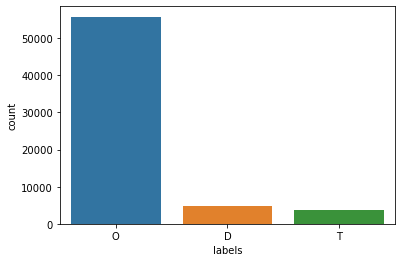

In [23]:
sns.countplot(df_corpus.labels)
plt.show()

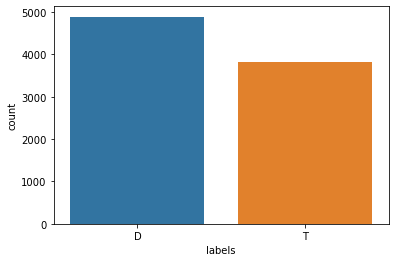

In [24]:
sns.countplot(df_corpus[df_corpus.labels != 'O']['labels'])
plt.show()

From above plot we can see that there is one(disease) to many(treatments) relation if not one to one.

## Building custome NER model using CRF

### Defining features for CRF

In [25]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, i):
    word = sentence[i][0]
    postag = sentence[i][1]
    features = [                  # Common features for all words.
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=%s' %postag,             # pos tag of the word
    'word.postag[:2]=%s' %postag[:2],  # first two characters of pos tag of the word
    ]

    if(i > 0):                        # Features for words that are not at the beginning of a sentence
        word1 = sentence[i-1][0]
        postag1 = sentence[i-1][1]
        features.extend([
        '-1:word.lower=' + word1.lower(), 
        '-1:word.isupper=%s' % word1.isupper(),
        '-1:word.isdigit=%s' % word1.isdigit(),
        '-1:word.startsWithCapital=%s' % word1[0].isupper(),
        '-1:word.pos=%s' %postag1,
        '-1:word.postag[:2]=%s' %postag1[:2],
        ])
    else:
        features.append('BEG')        # feature to track begin of sentence 

    if (i < len(sentence)-1):         # Features for words that are not at the end of a sentence     
        word1 = sentence[i+1][0]
        postag1 = sentence[i+1][1]
        features.extend({
            '+1:word.lower='+ word1.lower(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.isdigit=%s' % word1.isdigit(),
            '+1:word.startsWithCapital=%s' % word1[0].isupper(),
            '+1:word.postag=%s' %postag1,
            '+1:word.postag[:2]=%s' %postag1[:2],
            })
    
    else :
        features.append('END')       # feature to track end of sentence

    return features

### Extracting the features

In [26]:
# function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    sentence = model(sentence)
    sentence_list = [(word.text,word.pos_) for word in sentence]
    return [getFeaturesForOneWord(sentence_list, i) for i in range(len(sentence_list))]

In [27]:
# Testing above function on a single example sentence:
example_sentence = train_sentences[1]
example_sentence_labels = train_sentences_labels[1]

In [28]:
print(example_sentence)

example_sentence_Feature = getFeaturesForOneSentence(example_sentence)
example_sentence_Feature

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


[['word.lower=the',
  'word[-3:]=The',
  'word[-2:]=he',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=True',
  'word.pos=DET',
  'word.postag[:2]=DE',
  'BEG',
  '+1:word.postag=ADJ',
  '+1:word.postag[:2]=AD',
  '+1:word.isdigit=False',
  '+1:word.isupper=False',
  '+1:word.lower=total',
  '+1:word.startsWithCapital=False'],
 ['word.lower=total',
  'word[-3:]=tal',
  'word[-2:]=al',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=ADJ',
  'word.postag[:2]=AD',
  '-1:word.lower=the',
  '-1:word.isupper=False',
  '-1:word.isdigit=False',
  '-1:word.startsWithCapital=True',
  '-1:word.pos=DET',
  '-1:word.postag[:2]=DE',
  '+1:word.postag=ADJ',
  '+1:word.lower=cesarean',
  '+1:word.postag[:2]=AD',
  '+1:word.isdigit=False',
  '+1:word.isupper=False',
  '+1:word.startsWithCapital=False'],
 ['word.lower=cesarean',
  'word[-3:]=ean',
  'word[-2:]=an',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWith

In [29]:
print(f'number of words in a example_sentence is {len(example_sentence.split())}')
print(f'length of features of example_sentence is {len(example_sentence_Feature)}')

number of words in a example_sentence is 25
length of features of example_sentence is 25


In [30]:
print(f'features correspondoing to first word of example_sentence are:\n{example_sentence_Feature[0]}')

features correspondoing to first word of example_sentence are:
['word.lower=the', 'word[-3:]=The', 'word[-2:]=he', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=DET', 'word.postag[:2]=DE', 'BEG', '+1:word.postag=ADJ', '+1:word.postag[:2]=AD', '+1:word.isdigit=False', '+1:word.isupper=False', '+1:word.lower=total', '+1:word.startsWithCapital=False']


In [31]:
print(f'features correspondoing to second word of example_sentence are:\n{example_sentence_Feature[1]}')

features correspondoing to second word of example_sentence are:
['word.lower=total', 'word[-3:]=tal', 'word[-2:]=al', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=ADJ', 'word.postag[:2]=AD', '-1:word.lower=the', '-1:word.isupper=False', '-1:word.isdigit=False', '-1:word.startsWithCapital=True', '-1:word.pos=DET', '-1:word.postag[:2]=DE', '+1:word.postag=ADJ', '+1:word.lower=cesarean', '+1:word.postag[:2]=AD', '+1:word.isdigit=False', '+1:word.isupper=False', '+1:word.startsWithCapital=False']


In [32]:
print(f'features correspondoing to last word of example_sentence are:\n{example_sentence_Feature[-1]}')

features correspondoing to last word of example_sentence are:
['word.lower=)', 'word[-3:]=)', 'word[-2:]=)', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=PUNCT', 'word.postag[:2]=PU', '-1:word.lower=2144', '-1:word.isupper=False', '-1:word.isdigit=True', '-1:word.startsWithCapital=False', '-1:word.pos=NUM', '-1:word.postag[:2]=NU', 'END']


Function to get the labels for a sentence:

In [33]:
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [34]:
# Testing above function on a example_sentence:
example_sentence_label = getLabelsInListForOneSentence(example_sentence_labels)
print(f'length of labels corresponding to example_sentence is {len(example_sentence_label)}')

length of labels corresponding to example_sentence is 25


In [35]:
print(example_sentence_label)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Defining input and target variables

Defining the features' values for each sentence as input variable for CRF model in test and the train dataset :

In [36]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

Defining the labels as the target variable for test and the train dataset :

In [37]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_sentences_labels]

Y_test = [getLabelsInListForOneSentence(labels) for labels in test_sentences_labels]

Integrity check for mapping of X_train and Y_train:

In [38]:
mapping_list = [(len(X_train[i]), len(Y_train[i])) for i in range(0, len(X_train))]

invalid_mapping = []
for item in mapping_list:
    if item[0]!=item[1]:
        invalid_mapping.append(item)

if len(invalid_mapping)==0:
    print('There is NO invalid mapping')
else:
    print('Please check the mapping')

There is NO invalid mapping


### Building the CRF Model
We create a CRF object and pass training data to it. The model then "trains" and learns the weights for feature functions.

In [39]:
# Training the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100) #The max number of iterations for optimization algorithm =100. 
crf.fit(X_train, Y_train)  #Fitting the model on train data

CRF(keep_tempfiles=None, max_iterations=100)

## Model evaluation
* We will evaluate the model by predicting the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier and comparing it with ground truth.
* For model evalution we will use f1 score.

In [40]:
Y_pred = crf.predict(X_test)
print(f'F1 score is {round(metrics.flat_f1_score(Y_test, Y_pred, average="weighted"),2)}')

F1 score is 0.91


In [41]:
# Checking other metrics:
print(metrics.flat_classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           D       0.78      0.62      0.69      1450
           O       0.94      0.97      0.96     16127
           T       0.73      0.48      0.58      1041

    accuracy                           0.92     18618
   macro avg       0.82      0.69      0.74     18618
weighted avg       0.91      0.92      0.91     18618



Prediction on single test sentence:

In [42]:
id = 5
print("Sentence:",test_sentences[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: This study tested the hypothesis that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Identifying Diseases and Treatments using Custom NER
We will now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.
* Please note that here, we are assuming that if there is a disease in the sentences, then the treatment mentioned in that sentence can be assumed to be the treatment for that disease. Also, there is an assumption that the same treatment can work for different diseases.

In [43]:
def label_transitions(transition_features):             # Function to 
    for (label_from, label_to), weight in transition_features:
        print(f'{label_from} --> {label_to}    {weight}')

print("transitions : ")
label_transitions(Counter(crf.transition_features_).most_common())

transitions : 
T --> T    4.246139
D --> D    4.179135
O --> O    1.833385
O --> D    0.370941
T --> O    0.286403
D --> O    -1.896001
O --> T    -2.031645
D --> T    -2.135861


We can see that high number of transitions are T --> T and D --> D

In [44]:
disease_set = set()
for index in range(len(Y_pred)):
    match_object = re.finditer(r'(D |D)+',' '.join(Y_pred[index]))
    for match_obj in match_object:
        start,end = match_obj.start(), match_obj.end()
        res = [i for j in test_sentences[index].split() for i in (j, ' ')]
        word = ' '.join(res[start: end]).strip().replace('   ',' ')
        disease_set.add(word)

In [45]:
disease_treatment = {}
for disease in disease_set:
    disease_flag = 0
    for index in range(len(test_sentences)):
        if disease in test_sentences[index]:
            match_object_treatment = re.finditer(r'(T |T)+',' '.join(Y_pred[index]))
            treatment_in_sentence = re.findall(r'(T |T)+',' '.join(Y_pred[index]))
            if len(treatment_in_sentence)!=0:
                disease_flag = 1
            for match_obj in match_object_treatment:
                start,end = match_obj.start(), match_obj.end()
                result = [i for j in test_sentences[index].split() for i in (j, ' ')]
                treatment = ' '.join(result[start: end]).strip().replace('   ',' ')
                disease_treatment.setdefault(disease, set()).add(treatment)
            if disease_flag == 0:
                disease_treatment[disease]={'No treatment found in records'}

In [46]:
disease_treatment_df = pd.DataFrame(list(disease_treatment.items()),columns = ['disease','treatment']) 

In [47]:
disease_treatment_df.disease = disease_treatment_df.disease.apply(disease_substitute)
disease_treatment_df.treatment = disease_treatment_df.treatment.apply(treatment_substitute)

In [48]:
disease_treatment_df.head(10)

,disease,treatment
0,Myoepithelial carcinoma,[No treatment found in records]
1,esophageal achalasia,"[botulinum toxin injection , pneumatic dilatio..."
2,stable asthma,[No treatment found in records]
3,malignant melanoma,[leukocyte A recombinant interferon (rIFN-alph...
4,unstable angina or non-Q-wave myocardial infar...,[roxithromycin]
5,insensible fluid loss,[No treatment found in records]
6,Small cell lung cancer,[No treatment found in records]
7,advanced stage (TNM IIB-IVB) mycosis fungoides,[a combination chemotherapy program consisting...
8,ventricular tachycardia,[surgical therapy]
9,abdominal pain,[thoracic paravertebral block (tpvb)]


## Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [49]:
disease_treatment_df[disease_treatment_df.disease=='hereditary retinoblastoma']

,disease,treatment
296,hereditary retinoblastoma,[radiotherapy]


In [50]:
print(f'As per prediction, treatment for hereditary retinoblastoma is',disease_treatment_df[disease_treatment_df.disease=='hereditary retinoblastoma']['treatment'].values[0])

As per prediction, treatment for hereditary retinoblastoma is ['radiotherapy']


Lets check the sentence containing 'hereditary retinoblastoma' to validate our prediction:

In [51]:
for sentence in test_sentences:
    if 'hereditary retinoblastoma' in sentence:
        print(sentence)

< TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy


From above we can see that, radiotherapy is not actually the correct treatment for 'hereditary retinoblastoma'. In fact it is one of the risk increasing factor. 
Solution to above problem is Semantic processing which takes consideration of meaning/context of words in a sentence.

# Conclusion
* Even though Lexical and syntatic processing are crucial and helpful for natural language processing, many times they are not enough. We have to take help of Semantic processing as well.

In [52]:
print('Finish')

Finish
